# MMLDT-CSET 2021
# Short Course 2: 
# Mechanistic Machine Learning for Engineering and Applied Science
# (4) Introduction to Convolutional Neural Networks

Instructors: Prof. J.S. Chen, Xiaolong He, Kristen Susuki (UC San Diego)

---

1. The Architecture of the Visual Cortex
2. Convolutional Layers
    - Filters
    - Stacking Multiple Feature Maps
    - TensorFlow Implementation
    - Memory Requirements
3. Pooling Layers
    - Max Pooling
    - Average Pooling
4. Tackling Fashion MNIST With a CNN

# Setup

- Import a few common modules
- MatplotLib plots figures inline
- Check **Python ≥ 3.5**, **Scikit-Learn ≥ 0.20**, and **TensorFlow ≥ 2.0** (used in the next section).
- Prepare a function to save figures

In [1]:
# Python ≥ 3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥ 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥ 2.0 is required
import tensorflow as tf
import tensorflow.keras as keras
# from tensorflow import keras
assert tf.__version__ >= "2.0"

# Check number of available CPUs and GPUs
import multiprocessing
print("Number of GPUs Available: ", multiprocessing.cpu_count())
print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Number of GPUs Available:  12
Number of GPUs Available:  1


A couple utility functions to plot grayscale and RGB images:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

**Convolutional neural networks (CNNs)** emerged from the study of the
**brain’s visual cortex**, and they have been used in **image recognition** since
the 1980s. In the last few years, thanks to the increase in computational
power, the amount of available training data, and the techniques presented in
Chapter 11 for training deep nets, CNNs have managed to achieve
superhuman performance on some complex visual tasks. 

They power **image search services**, **self-driving cars**, **automatic video classification systems**, and more. 

Moreover, CNNs are not restricted to visual perception: they are also successful at many other tasks, such as **voice
recognition** and **natural language processing**. However, we will focus on visual applications for now.


We will explore 
- where CNNs came from, 
- what their building blocks look like, and 
- how to implement them using TensorFlow and Keras. 

# <font color='blue'>1 The Architecture of the Visual Cortex </font>

In 1958 and 1959, **David H. Hubel** and **Torsten Wiesel** performed a series of experiments on cats, which gives crucial insights into the structure of the **visual cortex**. They showed that


- Many neurons in the visual cortex have a small **local receptive field**, meaning they react only to visual stimuli located in a **limited region of the visual field**. 
    - For example, the local respective fields of five neurons are represented by **dashed circles** in the below figure.
    - The receptive fields of different neurons may **overlap**, and together they tile the whole visual field.


- Some neurons react only to images of **horizontal lines**, while others react only to lines with different **orientations**
    - Two neurons may have the same receptive field but react to different line orientations


- Some neurons have **larger receptive fields**, and they react to **more complex patterns** that are **combinations of the lower-level patterns**.


- These observations led to the idea: **higher-level neurons are based on outputs of neighboring lower-level neurons**.
    - In the below figure, each neuron is **connected only to a few neurons** from the previous layer.


<img src = "images/visual_cortex.PNG" width = "500">


- This powerful architecture is able to detect all sorts of complex patterns in any area of the visual field

### Convolutional Neural Networks

- These studies of the visual cortext inspired the **neocognitron**, introduced in 1980, which gradually evolved into what we now call **convolutional neural networks**.


- In 1998, Yann LeCun et al. introduced the famous **LeNet-5** architecture, widely used by banks to **recognize handwritten check numbers**. Apart from fully connected layers and sigmoid activation functions, this architecture has introduced two new building blocks: **convolutional layers** and **pooling layers**.

### Why not simply use a deep neural network with fully connected layers for image recognition tasks?

- Unfortunately, although this works fine for **small images** (e.g., MNIST), it breaks down for larger images because of the **huge number of parameters** it requires. 


- For example, a 100 × 100–pixel image has 10,000 pixels, and if the first layer has just 1,000 neurons, this means a total of **10 million connections**. And that’s just the first layer. 


- CNNs solve this problem using **partially connected layers** and **weight sharing**.

# <font color='blue'> 2 Convolutional Layers </font>

The most important building block of a CNN is the **convolutional layer**: 

- Unlike the neurons in a **fully connected hidden layer**, which are connected to all pixels in the input image, the neurons in the **1st convolutional layer** are only connected to **pixels in their receptive fields**, see below figure.


- Each neuron in the **2nd convolutional layer** is connected only to neurons located within a small rectangle in the 1st layer.


- This architecture allows the network to concentrate on **small low-level features** in the first hidden layer, then **assemble them into larger higher-level features** in the next hidden layer, and so on.

<img src = "images/CNN_local_receptive_fields.PNG" width = "400">


- This **hierarchical structure** is common in real-world images, which is one of the reasons why CNNs work so well for image recognition.

**Note**:

- All the **multilayer neural networks** we’ve looked at so far had layers composed of **a long line of neurons**, and we had to **flatten input images to 1D** before feeding them to the neural network. 


- In a CNN, **each layer is represented in 2D**, which makes it easier to match neurons with their corresponding inputs.

### Zero Padding

- A neuron located in row $i$, column $j$ of a given layer is connected to the outputs of the neurons in the previous layer located in rows $i$ to $i + f_h – 1$, columns $j$ to $j + f_w – 1$ , where $f_h$ and $f_w$ are the **height** and **width** of the **receptive field** (see below figure). 
    - For example, the neuron marked in **red** is located in row $i=4$, column $j=0$. With $f_h=f_w=3$, it is connected to the neurons in the previous layer located in rows 4 to 6, columns 0 to 2.


- In order for a layer to have the **same height and width** as the previous layer, it is common to **add zeros around the inputs**, as shown in the below figure.

<img src = "images/CNN_zero_padding.PNG" width = "400">

Can use `tf.pad(tensor, paddings, mode='CONSTANT', constant_values=0, name=None)` to perform one of the three modes of paddings: **"CONSTANT"**, **"REFLECT"**, and **"SYMMETRIC"**. [Documentation](https://www.tensorflow.org/api_docs/python/tf/pad)

- `paddings`: an integer tensor with shape $[n, 2]$, where $n$ is the rank (dimension) of tensor. For each dimension $D$ of input, 
    - paddings $[D, 0]$ indicates how many values to add **before the contents of tensor** in that dimension, and 
    - paddings $[D, 1]$ indicates how many values to add **after the contents of tensor in that dimension**. 


- `constant_values`: In **"CONSTANT"** mode, the **scalar** pad value to use. Must be same type as tensor.
    - **Zero padding**: `constant_values=0` and `mode="CONSTANT"`

In [3]:
A = tf.constant([[1,2,3], [4,5,6], [7,8,9]])
print(A)

tf.Tensor(
[[1 2 3]
 [4 5 6]
 [7 8 9]], shape=(3, 3), dtype=int32)


In [4]:
paddings = tf.constant([[2,2], [2,2]])
print(paddings)

tf.Tensor(
[[2 2]
 [2 2]], shape=(2, 2), dtype=int32)


In [5]:
A_pad = tf.pad(A, paddings, "CONSTANT")
print(A_pad)

tf.Tensor(
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 2 3 0 0]
 [0 0 4 5 6 0 0]
 [0 0 7 8 9 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]], shape=(7, 7), dtype=int32)


**Note**: $D=0$ is the **row dimension**. $D=1$ is the **column dimension**. 

In [6]:
paddings = tf.constant([[1,2], [1,3]])
print(paddings)

tf.Tensor(
[[1 2]
 [1 3]], shape=(2, 2), dtype=int32)


In [7]:
A_pad = tf.pad(A, paddings, "CONSTANT")
print(A_pad)

tf.Tensor(
[[0 0 0 0 0 0 0]
 [0 1 2 3 0 0 0]
 [0 4 5 6 0 0 0]
 [0 7 8 9 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]], shape=(6, 7), dtype=int32)


### Symmetric Padding

In [8]:
A = tf.constant([[1,2,3], [4,5,6], [7,8,9]])
print(A)

tf.Tensor(
[[1 2 3]
 [4 5 6]
 [7 8 9]], shape=(3, 3), dtype=int32)


In [9]:
paddings = tf.constant([[2,2], [2,2]])
print(paddings)

tf.Tensor(
[[2 2]
 [2 2]], shape=(2, 2), dtype=int32)


In [10]:
A_pad = tf.pad(A, paddings, "SYMMETRIC")
print(A_pad)

tf.Tensor(
[[5 4 4 5 6 6 5]
 [2 1 1 2 3 3 2]
 [2 1 1 2 3 3 2]
 [5 4 4 5 6 6 5]
 [8 7 7 8 9 9 8]
 [8 7 7 8 9 9 8]
 [5 4 4 5 6 6 5]], shape=(7, 7), dtype=int32)


### Reflect Padding

In [11]:
A = tf.constant([[1,2,3,4], [4,5,6,7], [7,8,9,10]])
print(A)

tf.Tensor(
[[ 1  2  3  4]
 [ 4  5  6  7]
 [ 7  8  9 10]], shape=(3, 4), dtype=int32)


In [12]:
paddings = tf.constant([[2,2], [2,2]])
print(paddings)

tf.Tensor(
[[2 2]
 [2 2]], shape=(2, 2), dtype=int32)


In [13]:
A_pad = tf.pad(A, paddings, "REFLECT")
print(A_pad)

tf.Tensor(
[[ 9  8  7  8  9 10  9  8]
 [ 6  5  4  5  6  7  6  5]
 [ 3  2  1  2  3  4  3  2]
 [ 6  5  4  5  6  7  6  5]
 [ 9  8  7  8  9 10  9  8]
 [ 6  5  4  5  6  7  6  5]
 [ 3  2  1  2  3  4  3  2]], shape=(7, 8), dtype=int32)


### Reducing Dimensionality by Strides

- It is also possible to connect a large input layer to a much smaller layer by **spacing out the receptive fields**, see below figure. This dramatically **reduces the model’s computational complexity**. 


- The shift from one receptive field to the next is called the **stride**. 
    - In this figure, a 5 x 7 input layer (plut zero padding) is connected to a 3 x 4 layer, using 3 x 3 respective fields and a stride of 2. 
    - In this example, the stride is the same in both directions.
    
<img src = "images/CNN_stride.PNG" width = "400">


- A neuron located in row $i$, column $j$ in the **upper layer** is connected to the outputs of the neurons in the previous layer located in rows $i × s_h$ to $i × s_h + f_h – 1$, columns $j × s_w$ to $j × s_w + f_w – 1$, where $s_h$ and $s_w$ are the **vertical** and **horizontal strides**.
    - For example, the neuron marked in red is located in row $i=2$, column $j=0$. With $f_h=f_w=3$ and $s_h=s_w=2$, it is connected to the neurons in the previous layer located in rows 4 to 6, columns 0 to 2.

# 2.1 Filters

As a neuron's weights are only **non-zero** when they are associated with the connection related to the receptive fields, the weights for the receptive field can be represented as a small image with a size of the receptive field. The figure below shows two possible sets of weights, called **filters** (or **convolutional kernels**). 
- The first one is represented as a black square with a **vertical white line in the middle**: it is a **7 × 7 matrix** full of 0s except for the central column, which is full of 1s;
    - Neurons using these weights will ignore everything in their receptive field except for the **central vertical line** since all inputs will get multiplied by 0, except for the ones located in the central vertical line.
    
    
- The second filter is a black square with a **horizontal white line in the middle**. 
    - neurons using these weights will ignore everything in their receptive field except for the central horizontal line.
    

<img src = "images/filters.png" width = "600">

- If all neurons in a layer use the **same vertical line filter** (and the same bias term), and you feed the network the **input image** shown in the bottom image, the layer will output the **top-left** image. Notice that the **vertical white lines get captured while the rest gets blurred.**


- Similarly, the upper-right image is what you get if all neurons use the **same horizontal line filter**; notice that the **horizontal white lines get captured while the rest is blurred out.** 


- Thus, a layer full of neurons using the **same filter** outputs a <font color='red'> **feature map** </font>, which **highlights the areas in an image that activate the filter the most**. 


- You do not have to define the filters manually: instead, during training <font color='red'> **the convolutional layer will automatically learn the most useful filters for its task** </font>, and the layers above will learn to combine them into more complex patterns. 

# 2.2 Stacking Multiple Feature Maps

- So far, the output of each convolutional layer is represented as a 2D layer, but in reality, a convolutional layer can have **multiple filters** (determined by users) and **outputs one feature map per filter**. 


- Thus, it is more accurate to represent the output of a convolutional layer in 3D, see below figure.


- It has **one neuron per pixel in each feature map** and <font color="red"> **all neurons within a given feature map share the same parameters** </font>, i.e., **the same weights and bias term**. Neurons in different feature maps use different parameters. 


- A neuron’s receptive field is the same as described earlier, but it **extends across all the previous layers’ feature maps**. 


- A convolutional layer simultaneously applies **multiple trainable filters** to its inputs, making it capable of detecting **multiple features** anywhere in its inputs.


<img src = "images/stacking_feature_maps.png" width = "500">


- **Input images** can also contain multiple sublayers: **one per color channel (layer)**. There are typically **three: red, green, and blue (RGB)**. 


- **Grayscale** images have just **one channel**, but some images may have much more. For example, satellite images that capture extra light frequencies (such as infrared).

### Note:

- The fact that **all neurons in a feature map share the same parameters** dramatically **reduces the number of parameters in the model**. Once the CNN has learned to recognize a pattern in one location, it can recognize it in any other location. 


- In contrast, once a regular DNN has learned to recognize a pattern in one location, it can recognize it only in that particular location

### Mathmatical Expression:
- A neuron located in row $i$, column $j$ of the feature map $k$ in a given convolutional layer $l$ is connected to the outputs of the neurons in the previous layer $l – 1$, located in rows $i × s_h$ to $i × s_h + f_h – 1$ and
columns $j × s_w$ to $j × s_w + f_w – 1$, **across all feature maps in layer $l – 1$**.


- Note that all neurons located in the same row $i$ and column $j$ but in **different feature maps** are connected to the outputs of the exact **same neurons** in the previous layer.


- The output of a neuron in a convolutional layer (layer $l$) is computed by

$$ z_{ij,k} = b_k + \sum_{u=0}^{f_h-1} \sum_{v=0}^{f_w-1} \sum_{k'=0}^{f_{n'}-1} x_{i'j',k'} \cdot w_{uv,k',k} \tag{1}$$
with 
$$ \begin{equation}
\begin{cases}
    i' & = i \times s_h + u \\
    j' & = j \times s_w + v 
\end{cases}
\end{equation} $$


- $z_{ij,k}$ is the output of the neuron located in row $i$, column $j$ in feature map $k$ of the convolutional layer (layer $l$).


- As explained earlier, $s_h$ and $s_w$ are the **vertical and horizontal strides**, $f_h$ and $f_w$ are the **height and width of the receptive field**, and $f_{n'}$ is the **number of feature maps** in the previous layer (layer $l – 1$).


- $x_{i'j',k'}$ is the output of the neuron located in layer $l – 1$, row $i′$, column $j′$, feature map $k′$ (or channel $k′$ if the previous layer is the input layer).


- $b_k$ is the bias term for feature map $k$ (in layer $l$). You can think of it as a knob that tweaks the overall brightness of the feature map $k$.


- $w_{uv,k',k}$ is the connection weight between any neuron in feature map $k$ of the layer $l$ and its input located at row $u$, column $v$ (**relative to the neuron’s receptive field**), and feature map $k′$ of the layer $l-1$.

# 2.3 TensorFlow Implementation

- In TensorFlow, each **input image** is typically represented as a **3D tensor of shape [height, width, channels]**. 


- A **mini-batch** is represented as a **4D tensor of shape [mini-batch size, height, width, channels]**. 


- The **weights** (filter) of a convolutional layer are represented as a **4D tensor of shape $[f_h, f_w, f_{n'}, f_n]$**.


- The **bias** terms of a convolutional layer are represented as a **1D tensor of shape $[f_n]$**.

The following code loads **two color images**, a Chinese temple and a flower, using Scikit-Learn’s `load_sample_image() `, then it creates **two filters** and applies them to both images, and finally it displays one of the resulting feature maps.

- The **pixel intensity** for each color channel is represented as a byte from 0 to 255, so we scale these features simply by dividing by 255, to get **floats** ranging from 0 to 1.


- Then we create **two 7 × 7 filters**, one with a **vertical white line in the middle**, and the other with a **horizontal white line in the middle**.


- We apply them to both images using the `tf.nn.conv2d()` function, which is part of TensorFlow’s low-level Deep Learning API. In this example, we use **zero padding** (`padding="same"`) and a **stride** of 1.


- Finally, we plot one of the resulting feature maps

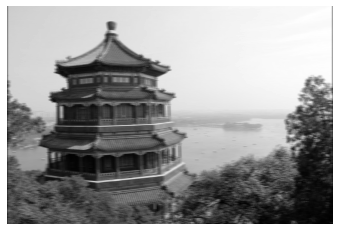

In [14]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# Convolution
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

# Plot feature map
plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off")
plt.show()

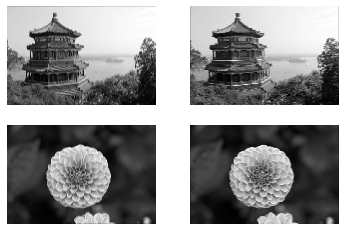

In [15]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [16]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


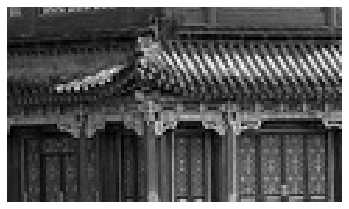

Saving figure china_vertical


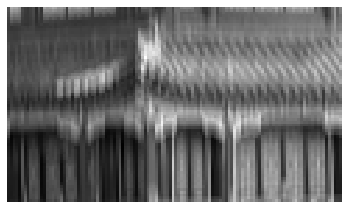

Saving figure china_horizontal


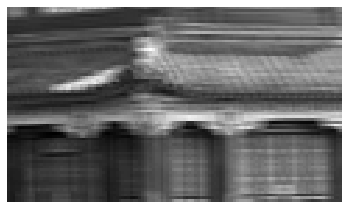

In [17]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

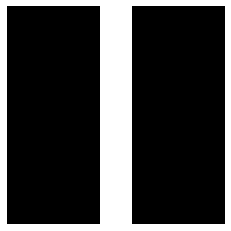

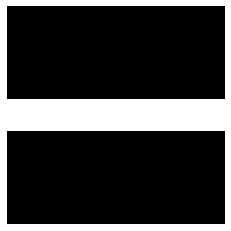

In [18]:
# Plot filters
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

More details of the line `outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")`:

- `images` is the **input mini-batch**, a 4D tensor, as explained earlier


- `filters` is the **set of filters to apply**, also a 4D tensor, as explained earlier


- `strides` is equal to 1, but it could also be a 1D array with four elements, where the two central elements are the vertical and horizontal strides ($s_h$ and $s_w$). The first and last elements must currently be equal to 1. They may one day be used to specify a **batch stride** (to skip some instances) and a **channel stride** (to skip some of the previous layer’s feature maps or channels).


- `padding` must be either `"same"` or `"valid"`:
    - If set to <font color="red"> "same" </font>, the convolutional layer uses <font color="red"> **zero padding** </font> if necessary. The **output size** is set to the **number of input neurons divided by the stride, rounded up**. 
        - For example, if the input size is 13 and the stride is 5 (see below figure), then the output size is 3, i.e., 13 / 5 = 2.6, rounded up to 3. Then **zeros are added as evenly as possible around the inputs**, as needed. 
        - When `strides=1`, the layer’s outputs will have the **same spatial dimensions** (width and height) as its inputs, hence the name `same`.
    
    - If set to <font color="red"> "valid" </font>, the convolutional layer <font color="red"> **does not use zero padding** </font> and may **ignore some rows and columns at the bottom and right** of the input image, depending on the stride, as shown in below figure (for simplicity, only the horizontal dimension is shown here, but of course the same logic applies to the vertical dimension). 
        - This means that every neuron’s receptive field lies strictly within **valid positions inside the input** (it does not go out of bounds), hence the name `valid`.

<img src = "images/tensorflow_padding.png" width = "400">

In this example we **manually defined the filters**, but in a real CNN you would normally **define filters as trainable variables** so the neural net can learn which filters work best


Instead of manually creating the variables, use the `keras.layers.Conv2D()`:

In [19]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

- This creates a `Conv2D` layer with **32 filters**, each 3 × 3, using a **stride** of 1 (both horizontally and vertically) and `"same"` **padding**, and applying the **ReLU** activation function to its outputs. 


- Convolutional layers have quite a few hyperparameters: you must choose the number of filters, their height and width, the strides, and the padding type. 


- As always, you can use **cross-validation** to find the right hyperparameter values, but this is very **time-consuming**. We will discuss **common CNN architectures** later, to give you some idea of which hyperparameter values work best in practice.

# 2.4 Memory Requirements

- Convolutional layers require a huge amount of RAM, especially during training, because the **reverse pass of backpropagation** requires all the intermediate values computed during the forward pass.


- For example, consider a convolutional layer with **5 × 5 filters**, outputting **200 feature maps of size 150 × 100**, with stride 1 and `"same"` padding. 
    - If the input is a 150 × 100 RGB image (**three channels**), then the number of parameters is (5 × 5 × 3 + 1) × 200 = **15,200** (the + 1 corresponds to the bias terms), which is fairly small compared to a fully connected layer. 
    - However, each of the 200 feature maps contains 150 × 100 neurons, and each of these neurons needs to compute a weighted sum of its 5 × 5 × 3 = **75 input**s: that’s a total of **225 million float multiplications**. Not as bad as a fully connected layer, but still quite computationally intensive. 
    - Moreover, if the feature maps are represented using **32-bit floats**, then the convolutional layer’s output will occupy 200 × 150 × 100 × 32 = **96 million bits (12 MB) of RAM**. And that’s just for **one instance**.
    - If a training batch contains **100 instances**, then this layer will use up **1.2 GB of RAM**
    

- During **inference**, i.e., when making a prediction for a new instance, the **RAM occupied by one layer can be released as soon as the next layer has been computed**, so you only need as much **RAM as required by two consecutive layers**. 


- But during **training** everything computed during the forward pass needs to be preserved for the reverse pass, so the amount of RAM needed is (at least) the **total amount of RAM required by all layers**.

### Note:

If training crashes because of an **out-of-memory error**, you can try 
- reducing the mini-batch size
- reducing dimensionality using a larger stride 
- removing a few layers
- using 16-bit floats instead of 32-bit floats
- distributing the CNN across multiple devices

# <font color='blue'> 3 Pooling Layers </font>

- The goal **pooling layers** is to **subsample** (i.e., **shrink**) the input image in order to reduce the **computational load**, the **memory usage**, and the **number of parameters** (thereby **limiting the risk of overfitting**).


- Like in convolutional layers, each neuron in a **pooling layer** is connected to the outputs of a limited number of neurons in the previous layer, located within a **small rectangular receptive field**. You must define its **size**, the **stride**, and the **padding** type, just like before. 


- However, a **pooling neuron has no weights**; all it does is **aggregate the inputs** using an **aggregation function** such as the **max** or **mean**. 

## 3.1 Max Pooling
- The figure below shows a <font color="red"> **max pooling layer** </font>, which is the **most common** type of pooling layer. 
    - We use a **2 × 2 pooling kernel**, with a **stride of 2** and **no padding**.
    - Only the max input value in each receptive field makes it to the next layer, while the other inputs are **dropped**. 
    - For example, in the **lower-left** receptive field, the input values are 1, 5, 3, 2, so only the **max** value, 5, is propagated to the next layer. 
    - Because of the stride of 2, the output image has **half the height** and **half the width** of the input image (rounded down since we use no padding).


<img src = "images/max_pooling.png" width = "500">


- <font color="red"> A pooling layer typically works on **every input channel independently**, so the **output depth is the same as the input depth** </font>.

### Translational Invariance
Other than reducing computations, memory usage, and the number of parameters, a max pooling layer also introduces some level of **invariance to small translations**, as shown in below figure.


- We assume that the **bright pixel**s have a lower value than **dark pixels**, and we consider three images (A, B, C) going through a **max pooling layer** with a **2 × 2 kernel** and **stride 2**. 


- Images B and C are the same as image A, but **shifted** by one and two pixels to the right. 


- The outputs of the max pooling layer for images A and B are **identical**. This is what **translation invariance** means. 


- For image C, the output is different: it is shifted one pixel to the right (but there is still **75% invariance**). 

<img src = "images/max_pooling_invariance.png" width = "400">


- By **nserting a max pooling layer every few layers** in a CNN, it is possible to get some level of translation invariance at a larger scale. 


- Max pooling offers a small amount of **rotational invariance** and a slight **scale invariance**. Such invariance (even if it is limited) can be useful in cases where the **prediction should not depend on these details**, such as in **classification** tasks.

### Downsides of Max Pooling
- It is obviously very destructive: even with a tiny **2 × 2 kernel** and a **stride of 2**, the output will be two times smaller in both directions (so its area will be **four times smaller**), simply **dropping 75% of the input values**. 


- In some applications, **invariance is not desirable**. Take **semantic segmentation** (the task of classifying each pixel in an image according to the object that pixel belongs to): obviously, if the input image is translated by one pixel to the right, the output should also be translated by one pixel to the right. The goal in this case is **equivariance**, not invariance: a small change to the inputs should lead to a corresponding small change in the output.

### TensorFlow Implementation

- The following code creates a **max pooling layer** using a **2 × 2 kernel**. 

- The **strides default to the kernel size**, so this layer will use a **stride of 2** (both horizontally and vertically). 

- By default, it uses `"valid"` padding, i.e., no padding at all

In [20]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [21]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


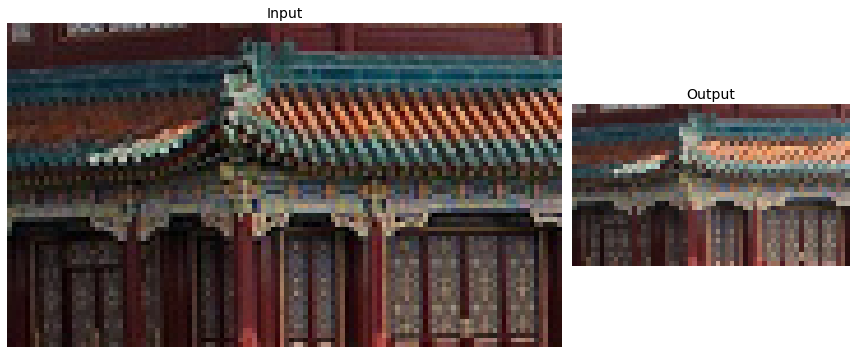

In [22]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

## 3.2 Average Pooling

- **Average pooling** works exactly like a max pooling layer, except it computes the **mean** rather than the **max**. 

- Average pooling layers used to be very popular, but people **mostly use max pooling layers** now, as they generally perform better. 

- This may seem surprising, since **computing the mean generally loses less information than computing the max**. 

- But on the other hand, **max pooling preserves only the strongest features, getting rid of all the meaningless ones**, so the next layers get a **cleaner signal** to work with. 

- Moreover, **max pooling offers stronger translation invariance than average pooling**, and it requires slightly less compute.

In [23]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [24]:
output_avg = avg_pool(cropped_images)

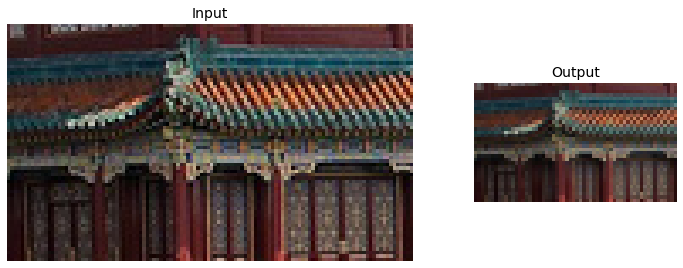

In [25]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

# <font color='blue'> 4 Tackling Fashion MNIST With a CNN </font> 

In [26]:
# Load and Split data sets
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


In [27]:
from functools import partial

# Use "partial" to define a Conv2D function with default parameters
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    # Convolutional layers and Max pooling layers
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    
    # Fully connected layers
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

- The **first layer** uses **64 fairly large filters (7 × 7)** but a **stride 1** because the input images are not very large. 
- `input_shape=[28, 28, 1]`, because the images are 28 × 28 pixels, with a **single color channel**, i.e., **grayscale**
- Next, we have a **max pooling layer** which uses a pool size of 2, so it divides each spatial dimension by a factor of 2. 


- Then we **repeat the same structure twice: two convolutional layers followed by a max pooling layer**. For larger images, we could repeat this structure several more times (the number of repetitions is a hyperparameter you can tune).


- Note that the **number of filters grows** as we climb up the CNN toward the output layer (it is initially 64, then 128, then 256): 
    - it makes sense for it to grow, since the number of **low-level features is often fairly low** (e.g., small circles, horizontal lines), 
    - but there are **many different ways to combine them into higher-level features**. 
    - It is a common practice to **double the number of filters after each pooling layer**: since a **pooling layer** divides each spatial dimension by a factor of 2, we can afford to **double the number of feature maps** in the next layer without fear of exploding the number of parameters, memory usage, or computational load.


- Next is the **fully connected network**, composed of **two hidden dense layers** and a **dense output layer**. Note that we must **flatten** its inputs, since a dense network expects a **1D array of features** for each instance. 


- We also add **two [dropout layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)**, with a **dropout rate of 50%** each, to **reduce overfitting**. 
    > The Dropout layer **randomly sets values of inputs (or hidden) neurons to 0** with a frequency of the dropout rate at each step **during training**. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
    
    > Note that the Dropout layer **only applies when training is set to True** such that no values are dropped during inference.

In [28]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 33s 608us/sample - loss: 0.6990 - accuracy: 0.7565 - val_loss: 0.3651 - val_accuracy: 0.8674
Epoch 2/10
55000/55000 [==============================] - 31s 570us/sample - loss: 0.4188 - accuracy: 0.8580 - val_loss: 0.3173 - val_accuracy: 0.8890
Epoch 3/10
55000/55000 [==============================] - 32s 573us/sample - loss: 0.3656 - accuracy: 0.8784 - val_loss: 0.3054 - val_accuracy: 0.8876
Epoch 4/10
55000/55000 [==============================] - 32s 573us/sample - loss: 0.3300 - accuracy: 0.8881 - val_loss: 0.3096 - val_accuracy: 0.8900
Epoch 5/10
55000/55000 [==============================] - 32s 581us/sample - loss: 0.3062 - accuracy: 0.8968 - val_loss: 0.2750 - val_accuracy: 0.8968
Epoch 6/10
55000/55000 [==============================] - 32s 577us/sample - loss: 0.2889 - accuracy: 0.9009 - val_loss: 0.2868 - val_accuracy: 0.8990
Epoch 7/10
55000/55000 [=====================

# References

1. Chapter 14 of [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)
2. Chpater 14 [Jupyter Notebook](https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb) of this book